## Compute Cleaner Decision Boundaries

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

In [2]:
from itertools import product
from scipy.spatial import ConvexHull
import warnings

def find_linear_regions_empirical(model, extent=[-1, 1, -1, 1], grid_resolution=1000, min_samples_per_region=5):
    """
    Find linear regions (polytopes) created by a ReLU network on a 2D input plane.
    
    Args:
        model: PyTorch model with ReLU activations (like BaarleNet)
        extent: [xmin, xmax, ymin, ymax] defining the input plane bounds
        grid_resolution: Number of points along each axis for sampling
        min_samples_per_region: Minimum points needed to define a region
    
    Returns:
        List of numpy arrays, each containing corner coordinates of a linear region
    """
    
    def get_relu_pattern(model, x):
        """Get the activation pattern (which ReLUs are active) for input x"""
        pattern = []
        current_x = x
        
        with torch.no_grad():
            for layer in model.layers:
                if isinstance(layer, torch.nn.Linear):
                    current_x = layer(current_x)
                elif isinstance(layer, torch.nn.ReLU):
                    # Record which neurons are active (>0)
                    active = (current_x > 0).float()
                    pattern.append(active)
                    current_x = torch.relu(current_x)
        
        # Flatten and convert to tuple for hashing
        return tuple(torch.cat(pattern, dim=-1).flatten().tolist())
    
    # Create a grid of sample points
    x_vals = np.linspace(extent[0], extent[1], grid_resolution)
    y_vals = np.linspace(extent[2], extent[3], grid_resolution)
    
    # Dictionary to store points by their activation pattern
    pattern_to_points = {}
    
    print(f"Sampling {grid_resolution}x{grid_resolution} points to find activation patterns...")
    
    # Sample points and group by activation pattern
    for i, x in enumerate(x_vals):
        if i % (grid_resolution // 10) == 0:
            print(f"Progress: {i/grid_resolution*100:.1f}%")
            
        for y in y_vals:
            point = torch.tensor([[x, y]], dtype=torch.float32)
            pattern = get_relu_pattern(model, point)
            
            if pattern not in pattern_to_points:
                pattern_to_points[pattern] = []
            pattern_to_points[pattern].append([x, y])
    
    print(f"Found {len(pattern_to_points)} distinct activation patterns")
    
    # Convert regions to convex hulls and find corner points
    linear_regions = []
    
    for pattern, points in pattern_to_points.items():
        if len(points) < min_samples_per_region:
            continue
            
        points_array = np.array(points)
        
        try:
            # Find convex hull of points in this region
            hull = ConvexHull(points_array)
            corners = points_array[hull.vertices]
            linear_regions.append(corners)
            
        except Exception as e:
            warnings.warn(f"Could not compute convex hull for region with {len(points)} points: {e}")
            continue
    
    print(f"Successfully extracted {len(linear_regions)} linear regions")
    
    # Refine boundaries by finding exact hyperplane intersections
    refined_regions = []
    
    for region_corners in linear_regions:
        # For small regions or those touching boundaries, use the sampled corners
        # For larger regions, we could implement exact hyperplane intersection finding
        refined_regions.append(region_corners)
    
    return refined_regions


def visualize_regions(regions, extent=[-1, 1, -1, 1], figsize=(6, 6)):
    """
    Helper function to visualize the found regions (requires matplotlib)
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.patches import Polygon
        import matplotlib.colors as mcolors
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Generate colors for each region
        colors = list(mcolors.TABLEAU_COLORS.values())
        
        for i, corners in enumerate(regions):
            color = colors[i % len(colors)]
            
            # Create polygon for this region
            polygon = Polygon(corners, alpha=0.3, facecolor=color, edgecolor='black', linewidth=0.5)
            ax.add_patch(polygon)
            
            # Mark corners
            # ax.scatter(corners[:, 0], corners[:, 1], c='red', s=10, zorder=5, alpha=0.5)
        
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Linear Regions of ReLU Network ({len(regions)} regions)')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("matplotlib not available for visualization")

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
# belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
# netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords_all, belgium_coords_all))
y=np.concatenate((np.zeros(len(netherlands_coords_all)), np.ones(len(belgium_coords_all)))).astype('int')

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

In [14]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig=plt.figure(0,(6,6))
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    with torch.no_grad():
        probe_logits=model(torch.tensor(probe).float())
        probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
        probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    return probe_logits

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from PIL import Image

def viz_and_save_heatmaps(model, save_dir="/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/heatmaps", model_name="model", rez=960):
    """
    Generate and save heatmaps for a PyTorch model's output regions.
    
    Args:
        model: PyTorch model that takes 2D input and outputs 2 channels
        save_dir: Directory to save the heatmap images
        model_name: Base name for the saved files
        rez: Resolution for the heatmap generation
    """
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Create probe grid at higher resolution
    probe = np.zeros((rez, rez, 2))
    for j, xx in enumerate(np.linspace(-1, 1, rez)):
        for k, yy in enumerate(np.linspace(-1, 1, rez)):
            probe[j, k] = [yy, xx]
    
    probe = probe.reshape(rez**2, -1)
    
    # Get model predictions
    with torch.no_grad():
        probe_logits = model(torch.tensor(probe).float())
        probe_logits = probe_logits.detach().numpy().reshape(rez, rez, 2)
    
    # Get argmax predictions for each pixel
    predictions = np.argmax(probe_logits, axis=2)
    
    # Define colors
    YELLOW = '#ffd35a'
    BLUE = '#65c8d0'
    
    # Create and save heatmaps for each channel
    colors = [BLUE, YELLOW]
    
    for channel in range(2):
        # Create binary mask for this channel
        channel_mask = (predictions == channel).astype(float)
        
        # Create RGBA image
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, rez)
        ax.set_ylim(0, rez)
        ax.axis('off')
        
        # Create custom colormap: transparent where mask is 0, solid color where mask is 1
        color_rgb = [int(colors[channel][1:3], 16)/255, 
                     int(colors[channel][3:5], 16)/255, 
                     int(colors[channel][5:7], 16)/255]
        
        # Create binary colormap
        cmap_colors = [(0, 0, 0, 0),  # Transparent for value 0
                       (color_rgb[0], color_rgb[1], color_rgb[2], 1)]  # Solid color for value 1
        cmap = ListedColormap(cmap_colors)
        
        # Plot the binary mask (flip vertically to match image coordinates)
        im = ax.imshow(np.flipud(channel_mask), 
                      extent=[0, rez, 0, rez],
                      cmap=cmap,
                      vmin=0, vmax=1)
        
        # Save as PNG with transparency
        filename = f"{model_name}_{channel}.png"
        filepath = os.path.join(save_dir, filename)
        
        plt.savefig(filepath, 
                   bbox_inches='tight', 
                   pad_inches=0, 
                   transparent=True, 
                   dpi=100)
        
        plt.close()
        
        print(f"Saved {filename} to {save_dir}")
    
    print(f"Heatmaps saved as {model_name}_0.png and {model_name}_1.png")

In [58]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

def find_smooth_contours(
    boolean_image: np.ndarray,
    min_contour_area: int = 50,
    gaussian_sigma: float = 0.5,
    method: str = 'interpolate',  # 'interpolate', 'subsample', or 'none'
    num_points: int = 100,
    epsilon_factor: float = 0.001,
    closing_kernel_size: int = 3
) -> List[np.ndarray]:
    """
    Find smooth borders around contiguous regions in a boolean image.
    
    Parameters:
    -----------
    boolean_image : np.ndarray
        2D boolean array where True/1 represents regions of interest
    min_contour_area : int
        Minimum area threshold for contours to be included
    gaussian_sigma : float
        Standard deviation for Gaussian smoothing before contour detection (light smoothing)
    method : str
        Smoothing method: 'interpolate' (uniform sampling), 'subsample' (Douglas-Peucker), 'none' (original points)
    num_points : int
        Number of points for 'interpolate' method
    epsilon_factor : float
        Approximation accuracy factor for 'subsample' method (as fraction of perimeter)
    closing_kernel_size : int
        Kernel size for morphological closing to fill small gaps
    
    Returns:
    --------
    List[np.ndarray]
        List of smooth contours, each as Nx2 array of (x,y) coordinates normalized to [-1,1]
        First and last points are identical for loop closure
    """
    
    # Convert boolean to uint8 if needed
    if boolean_image.dtype == bool:
        image = boolean_image.astype(np.uint8) * 255
    else:
        image = (boolean_image > 0).astype(np.uint8) * 255
    
    # Apply morphological closing to fill small gaps
    if closing_kernel_size > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                         (closing_kernel_size, closing_kernel_size))
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    
    # Apply very light Gaussian smoothing to reduce pixelation
    if gaussian_sigma > 0:
        image = gaussian_filter(image.astype(float), sigma=gaussian_sigma)
        image = (image > 127).astype(np.uint8) * 255
    
    # Find all contours including holes (enclaves)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    
    # Get image dimensions for normalization
    height, width = boolean_image.shape
    max_dim = max(height, width)
    
    smooth_contours = []
    
    for i, contour in enumerate(contours):
        # Filter by area
        area = cv2.contourArea(contour)
        if area < min_contour_area:
            continue
        
        # Convert to proper format
        points = contour.reshape(-1, 2).astype(float)
        
        if len(points) < 3:
            continue
        
        # Determine if this is an external contour or a hole
        # hierarchy[0][i] = [next, previous, first_child, parent]
        is_hole = hierarchy[0][i][3] != -1  # Has a parent = it's a hole
        
        # Apply smoothing method
        if method == 'subsample':
            # Douglas-Peucker algorithm for intelligent subsampling
            epsilon = epsilon_factor * cv2.arcLength(contour, True)
            simplified = cv2.approxPolyDP(contour, epsilon, True)
            points = simplified.reshape(-1, 2).astype(float)
            processed_contour = points
            
        elif method == 'interpolate':
            # Uniform interpolation along the contour
            processed_contour = uniform_resample_contour(points, num_points)
            
        else:  # method == 'none'
            processed_contour = points
        
        # For holes, reverse the point order to maintain consistent winding
        if is_hole:
            processed_contour = processed_contour[::-1]
        
        # Normalize coordinates to [-1, 1] range
        center_x, center_y = width / 2, height / 2
        normalized_contour = np.zeros_like(processed_contour)
        normalized_contour[:, 0] = (processed_contour[:, 0] - center_x) / (max_dim / 2)
        normalized_contour[:, 1] = (processed_contour[:, 1] - center_y) / (max_dim / 2)
        
        # Ensure loop closure by repeating first point
        normalized_contour = np.vstack([normalized_contour, normalized_contour[0:1]])
        
        smooth_contours.append(normalized_contour)
    
    return smooth_contours


def uniform_resample_contour(points: np.ndarray, num_points: int) -> np.ndarray:
    """
    Resample contour points to have uniform spacing along the perimeter.
    Preserves shape while providing consistent point density.
    """
    # Calculate cumulative distance along contour
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
    cumulative_dist = np.concatenate([[0], np.cumsum(distances)])
    
    # Add closing distance to complete the loop
    closing_dist = np.sqrt(np.sum((points[-1] - points[0])**2))
    total_perimeter = cumulative_dist[-1] + closing_dist
    
    # Create uniform sampling points along perimeter
    uniform_distances = np.linspace(0, total_perimeter, num_points + 1)[:-1]  # Exclude last point (same as first)
    
    # Handle the wrap-around by extending the contour
    extended_points = np.vstack([points, points[0:1]])  # Add first point at end
    extended_cumulative = np.concatenate([cumulative_dist, [total_perimeter]])
    
    # Interpolate to get uniform points
    interp_x = interp1d(extended_cumulative, extended_points[:, 0], kind='linear')
    interp_y = interp1d(extended_cumulative, extended_points[:, 1], kind='linear')
    
    uniform_x = interp_x(uniform_distances)
    uniform_y = interp_y(uniform_distances)
    
    return np.column_stack([uniform_x, uniform_y])


def visualize_contours(
    boolean_image: np.ndarray, 
    smooth_contours: List[np.ndarray],
    show_original: bool = True
) -> None:
    """
    Visualize the original image and extracted smooth contours.
    
    Parameters:
    -----------
    boolean_image : np.ndarray
        Original boolean image
    smooth_contours : List[np.ndarray]
        List of smooth contours from find_smooth_contours()
    show_original : bool
        Whether to show the original image as background
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot original image
    ax1.imshow(boolean_image, cmap='gray', origin='lower')
    ax1.set_title('Original Boolean Image')
    ax1.set_xlabel('X (pixels)')
    ax1.set_ylabel('Y (pixels)')
    
    # Plot normalized smooth contours
    if show_original:
        # Show original image in normalized coordinates for reference
        height, width = boolean_image.shape
        max_dim = max(height, width)
        extent = [-width/(max_dim), width/(max_dim), -height/(max_dim), height/(max_dim)]
        ax2.imshow(boolean_image, cmap='gray', alpha=0.3, extent=extent, origin='lower')
    
    # Plot smooth contours
    colors = plt.cm.tab10(np.linspace(0, 1, len(smooth_contours)))
    for i, contour in enumerate(smooth_contours):
        ax2.plot(contour[:, 0], contour[:, 1], 
                color=colors[i], linewidth=2, 
                label=f'Contour {i+1}')
    
    ax2.set_xlim(-1.1, 1.1)
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Smooth Normalized Contours')
    ax2.set_xlabel('Normalized X')
    ax2.set_ylabel('Normalized Y')
    
    if len(smooth_contours) <= 10:  # Only show legend if not too many contours
        ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [7]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [12]:
model_path='../models/one_layer_1024_nuerons_long.pth'
model = BaarleNet([1024])
model.load_state_dict(torch.load(model_path))
viz_scales=[0.07, 0.07, 0.04]
num_neurons=[1024, 1024, 2]

# model_path='../models/one_layer_10k_neurons_long.pth'
# model = BaarleNet([10000])
# model.load_state_dict(torch.load(model_path))
# viz_scales=[0.07, 0.07, 0.04]
# num_neurons=[10000, 10000, 2]

# model_path='../models/one_layer_100k_neurons_long.pth'
# model = BaarleNet([100000])
# model.load_state_dict(torch.load(model_path))
# viz_scales=[0.07, 0.07, 0.04]
# num_neurons=[100000, 100000, 2]

0.9792769366516102


<Figure size 640x480 with 0 Axes>

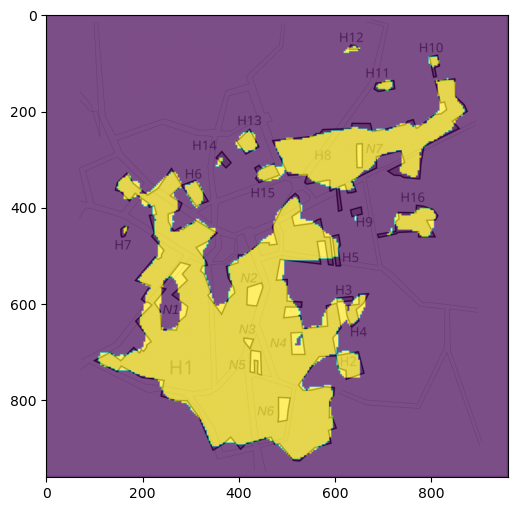

In [15]:
outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); probe_logits=viz_descision_boundary(model)

In [28]:
boolean_img=np.argmax(probe_logits,2)

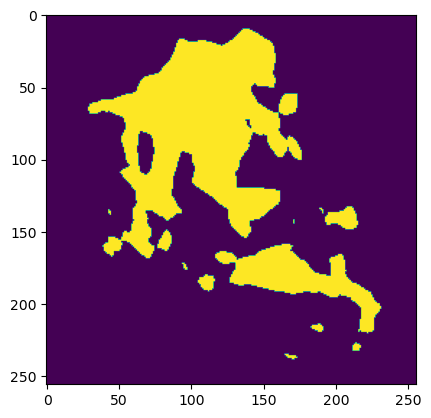

In [29]:
plt.imshow(boolean_img)

In [30]:
boolean_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [61]:
contours_interp = find_smooth_contours(
    boolean_img,
    min_contour_area=1,
    gaussian_sigma=0.1,
    method='subsample',
    num_points=100
)

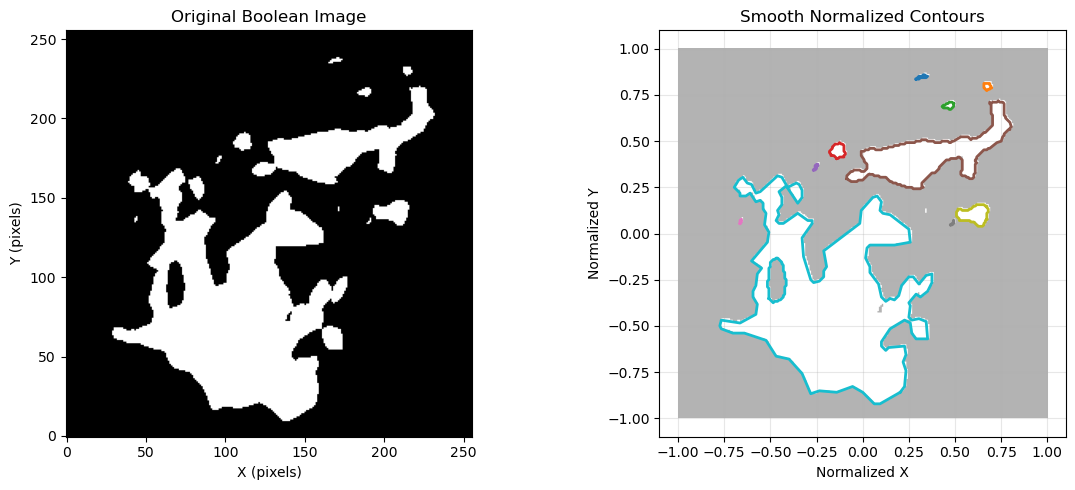

In [62]:
visualize_contours(boolean_img, contours_interp)

In [66]:
import pickle

In [67]:
# np.save('../models/one_layer_1024_nuerons_long_borders.p', contours_interp)
with open('../models/one_layer_1024_nuerons_long_borders.p', 'wb') as file:
    pickle.dump(contours_interp, file)

In [69]:
model_path='../models/one_layer_10k_neurons_long.pth'
model = BaarleNet([10000])
model.load_state_dict(torch.load(model_path))
viz_scales=[0.07, 0.07, 0.04]
num_neurons=[10000, 10000, 2]

0.977096176657921


<Figure size 640x480 with 0 Axes>

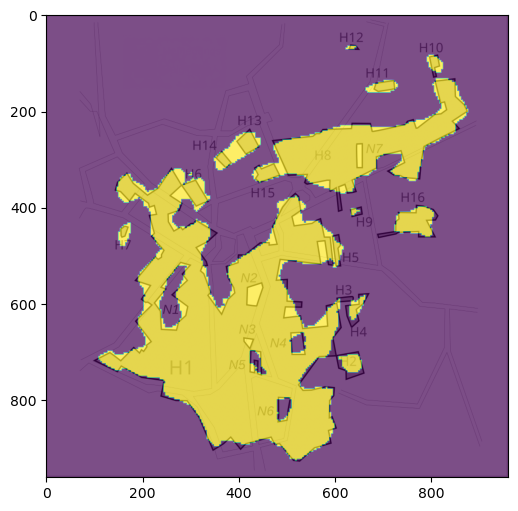

In [70]:
outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); probe_logits=viz_descision_boundary(model)

In [71]:
boolean_img=np.argmax(probe_logits,2)

In [72]:
contours_interp = find_smooth_contours(
    boolean_img,
    min_contour_area=1,
    gaussian_sigma=0.1,
    method='subsample',
    num_points=100
)

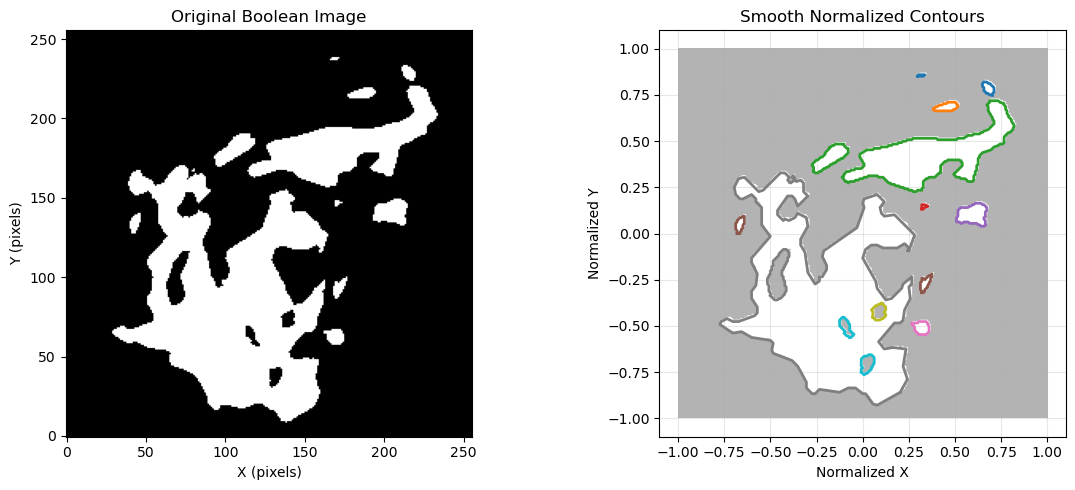

In [73]:
visualize_contours(boolean_img, contours_interp)

In [74]:
# np.save('../models/one_layer_1024_nuerons_long_borders.p', contours_interp)
with open('../models/one_layer_10k_neurons_long_border.p', 'wb') as file:
    pickle.dump(contours_interp, file)

In [75]:
model_path='../models/one_layer_100k_neurons_long.pth'
model = BaarleNet([100000])
model.load_state_dict(torch.load(model_path))
viz_scales=[0.07, 0.07, 0.04]
num_neurons=[100000, 100000, 2]

In [ ]:
outputs_batch = model(X_tensor)
accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)

print(accuracy); probe_logits=viz_descision_boundary(model)

In [ ]:
boolean_img=np.argmax(probe_logits,2)

In [ ]:
contours_interp = find_smooth_contours(
    boolean_img,
    min_contour_area=1,
    gaussian_sigma=0.1,
    method='subsample',
    num_points=100
)

In [ ]:
visualize_contours(boolean_img, contours_interp)

In [ ]:
# np.save('../models/one_layer_1024_nuerons_long_borders.p', contours_interp)
with open('../models/one_layer_100k_neurons_long_border.p', 'wb') as file:
    pickle.dump(contours_interp, file)